**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
!wget https://gist.githubusercontent.com/Yegorov/dc61c42aa4e89e139cd8248f59af6b3e/raw/20ac954e202fe6a038c2b4bb476703c02fe0df87/ya.py
!chmod +x ya.py
!./ya.py https://disk.yandex.ru/d/QPOw4hk84-se_w ./

--2022-08-26 05:34:40--  https://gist.githubusercontent.com/Yegorov/dc61c42aa4e89e139cd8248f59af6b3e/raw/20ac954e202fe6a038c2b4bb476703c02fe0df87/ya.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 723 [text/plain]
Saving to: ‘ya.py’

ya.py               100%[===================>]     723  --.-KB/s    in 0s      

2022-08-26 05:34:40 (39.3 MB/s) - ‘ya.py’ saved [723/723]

--2022-08-26 05:34:41--  https://downloader.disk.yandex.ru/disk/dcfc2bc0b23948739cc97644540d44b3cd69266353c0caca386c91be3d1a4a49/630893b1/_gIe7sqhiKGWvpES7oGEV4LBmE3mWZFnEs8QSgwfnop2zSm1XUdSGhsGQNyfSRay16J6z6P2MFmGUJp4elnHUA%3D%3D?uid=0&filename=data.zip&disposition=attachment&hash=Xsh98wiJiWn2t1I0wKL9nchDkGZQSAbOJ6BZci%2B3foEw4jU1THxu4mw5xq7jkf78q/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=

In [3]:
!unzip data.zip

Archive:  data.zip
replace data/test/gt/0_um_road_000071.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
!pip install albumentations==1.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import os
import cv2
import numpy as np

import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
from math import ceil

number_subsamples = 4
original_height, original_width = 370, 370
min_height, min_width = (ceil(i/ 2**number_subsamples + 2) * 2**number_subsamples for i in (original_height, original_width))
min_height, min_width

(416, 416)

In [31]:
from albumentations.core.composition import OneOf
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

img_transformation = dict()
img_transformation['aug'] = A.Compose([
    A.Sequential([
        A.OneOf([ #colors
            A.ColorJitter(brightness=1.0, saturation=1.0, hue=1.0, p=0.7),
            A.CLAHE(p=0.3),
            A.FancyPCA(p=0.5),
            A.transforms.InvertImg(p=0.2),
            A.transforms.RGBShift(p=0.4)
        ], p=0.7),
        A.OneOf([ #blur 
            A.AdvancedBlur(blur_limit=(21, 51), sigmaX_limit=(0.5, 2.5), sigmaY_limit=(0.5, 2.5), p=0.5),
            A.transforms.Downscale(scale_min=0.3, scale_max=0.7, p=0.5),
            A.Emboss(p=0.3),
            A.ISONoise(p=0.4)
        ], p=0.5),
        A.OneOf([ #Channels
            A.dropout.channel_dropout.ChannelDropout((1, 2)),
            A.transforms.ChannelShuffle(),
        ], p=0.3),
        A.OneOf([ #weather
            A.transforms.RandomFog(p=0.4),
            A.transforms.RandomRain(p=0.6),
            A.transforms.RandomShadow(p=0.5),
            A.transforms.RandomSunFlare(p=0.4, src_radius=100)
        ], p=0.4)
    ], p=0.7),
    A.OneOf([ #geometric
        A.geometric.rotate.Rotate(limit=40, p=0.6),
        A.geometric.transforms.Affine(scale=(0.7, 1.0), translate_percent=(0.05, 0.1), rotate=(-34, 34), keep_ratio=True, p=0.6),
        A.crops.transforms.RandomSizedCrop(min_max_height=(int(0.6 * original_height), int(original_height)),
                                           height=original_height, width=original_width, w2h_ratio=1.0, p=0.6),
    ], p=0.7),
    A.HorizontalFlip(p=0.5),
    A.PadIfNeeded(min_height, min_width, always_apply=True, border_mode=0)
])
img_transformation['eval'] = A.Compose([A.PadIfNeeded(min_height, min_width, always_apply=True, border_mode=0), 
                                        ToTensorV2(always_apply=True)])
img_transformation['conclusion'] = A.Compose([A.CenterCrop(height=original_height, width=original_width, always_apply=True)])

In [32]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform, aug=None,):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
        self.aug = aug
        self.cache = dict()
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        if idx in self.cache:
            image, mask = self.cache[idx] 
        else:     
            im_name = self.images[idx]
            mask_name = self.masks[idx]
            
            image = (cv2.imread(im_name)[:,:,::-1]) # / 255.0).astype(np.float32)  # ::-1 to convert from BGR to RGB
            mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
            mask = (mask > 0).astype(np.float32)

            self.cache[idx] = (image, mask)
        
        if self.aug:
            sample = self.aug(
                image=image,
                mask=mask,
            )
        else:
            sample = {
                'image': image,
                'mask': mask,
            }
        sample = self.transform(image=sample['image'], mask=sample['mask'])
        return sample

In [94]:
from sklearn.model_selection import train_test_split


train = (get_paths("data/train/images"), get_paths("data/train/gt"))
x_train, x_valid, y_train, y_valid = train_test_split(train[0], train[1], test_size=0.2, random_state=1, shuffle=True)

train = (x_train, y_train)
valid = (x_valid, y_valid)
test = (get_paths('data/test/images'), get_paths('data/test/gt'))



In [95]:
datasets = {
    'train': RoadDataset(train[0], train[1], transform=img_transformation['eval'], aug=img_transformation['aug']),
    'valid': RoadDataset(valid[0], valid[1], transform=img_transformation['eval'], aug=img_transformation['aug']),
    'test': RoadDataset(test[0], test[1], transform=img_transformation['eval'], aug=None)
}

torch.uint8
shape of the image: 288 is torch.Size([3, 416, 416])
shape of the mask: 288 is torch.Size([416, 416]), max: 1.0, min: 0.0


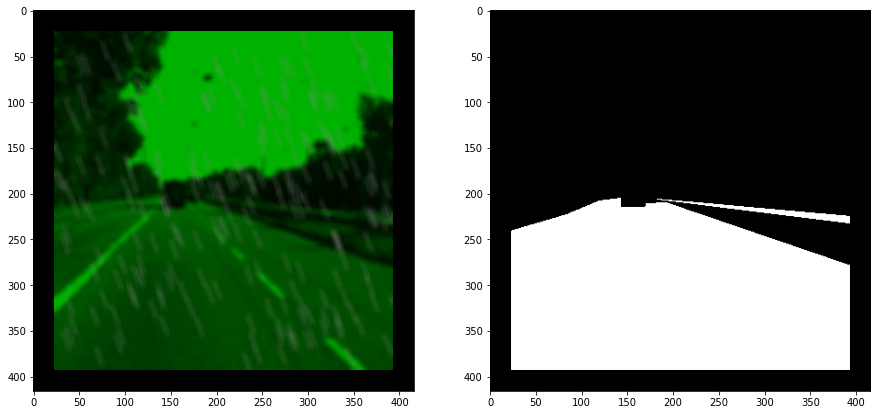

In [109]:
import numpy as np
import torch
from torchvision.transforms import CenterCrop


idx = int(np.random.randint(0, len(datasets['train'])))
sample = datasets['train'][idx]
print(sample['image'].dtype)
print(f'shape of the image: {idx} is {sample["image"].shape}')
print(f'shape of the mask: {idx} is {sample["mask"].shape}, max: {torch.max(sample["mask"])}, min: {torch.min(sample["mask"])}')


plt.figure(figsize=(15, 9))
plt.subplot(1, 2, 1)
plt.imshow(sample['image'].detach().cpu().numpy().transpose((1, 2, 0)))
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(sample['mask']), cmap='gray', vmin=0, vmax=1)

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [36]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

In [37]:
from torch import nn
from torchvision.transforms import CenterCrop



class Concatenate(nn.Module):
    def __init__(self, dim=1):
        super(Concatenate, self).__init__()
        self.dim = 1
    
    def forward(self, first, second):
        return torch.concat((first, second), dim=self.dim)



In [73]:
from typing import Union


class DownSampler(nn.Module):
    def __init__(self, in_channels: int,
                 out_channels: int,
                 activation: nn.Module,
                 normalization: nn.Module,
                 dropout: nn.Module=None,
                 padding: Union[str, int]='same',
                 pooling: bool=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = padding
        self.pooling = pooling
        self.activation = activation
        self.normalization = normalization
        self.dropout = dropout

        self.triplets = nn.Sequential(
                            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding, bias=False),
                            self.normalization(num_channels=self.out_channels),
                            self.activation(),
                            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding, bias=False),
                            self.normalization(num_channels=self.out_channels),
                            self.activation()
        )
    
        self.before_downsampling = None
        if self.pooling:
            self.downsampler = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    def forward(self, input):
        input = self.triplets(input)

        if self.dropout:
            input = self.dropout(input)
        if self.pooling:
            self.before_downsampling = torch.clone(input)
            input = self.downsampler(input)
        return input

        

In [74]:
from functools import partial

input = torch.rand(size=(5, 3, 128, 128))
layer = DownSampler(3, 10, nn.ELU, partial(nn.GroupNorm, num_groups=2), nn.Dropout2d(0.2))
downgraded = layer(input)
downgraded.shape

torch.Size([5, 10, 64, 64])

In [75]:
class UpSampler(nn.Module):
    def __init__(self, in_channels: int,
                 out_channels: int,
                 activation: nn.Module,
                 normalization: nn.Module,
                 dropout: nn.Module=None,
                 up_mode: str='transpose',
                 padding: Union[str, int]='same'):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.activation = activation
        self.normalization = normalization
        self.up_mode = up_mode
        self.padding = padding
        self.dropout = dropout

        self.triplets = nn.Sequential(
                            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding, bias=False),
                            self.normalization(num_channels=self.out_channels),
                            self.activation(),
                            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding, bias=False),
                            self.normalization(num_channels=self.out_channels),
                            self.activation()
        )
        
        self.upsampler = self._get_upsampler(self.out_channels, self.out_channels, self.up_mode)
        
    def _get_upsampler(self, in_channels: int,
                       out_channels: int,
                       up_mode: str = 'transpose'):
        if up_mode == 'transpose':
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        else:
            return nn.Upsample(scale_factor=2.0, mode=up_mode)

    def forward(self, input):
        input = self.triplets(input)
        if self.dropout:
            input = self.dropout(input)
        input = self.upsampler(input)
        return input



In [76]:
upsampler = UpSampler(10, 20, nn.ELU, partial(nn.GroupNorm, num_groups=2), nn.Dropout2d(p=0.2))
upsampler(downgraded).shape

torch.Size([5, 20, 128, 128])

In [81]:
from torchvision.transforms import CenterCrop

class UNet(nn.Module):
    def __init__(self, num_downsample: int,
                 in_channels: int,
                 out_channels: int,
                 start_filters: int,
                 activation: nn.Module,
                 normalization: nn.Module,
                 dropout: nn.Module=None,
                 up_mode: str='transpose',
                 padding: Union[str, int]='same'):
        super().__init__()
        self.num_downsample = num_downsample
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.start_filters = start_filters
        self.activation = activation
        self.normalization = normalization
        self.up_mode = up_mode
        self.padding = padding
        self.dropout = dropout
        self.concater = Concatenate()

        self.downsample_layers = nn.Sequential()
        for i in range(num_downsample):
            cur_in_channels = self.in_channels if i == 0 else cur_out_channels
            cur_out_channels = self.start_filters * 2 ** i
            self.downsample_layers.add_module(f'down_{i}', DownSampler(cur_in_channels, cur_out_channels, self.activation,\
                                                                       self.normalization, self.dropout, self.padding, pooling=True))
        
        self.bridge = UpSampler(cur_out_channels, cur_out_channels, self.activation,\
                                self.normalization, self.dropout, padding=self.padding)
        
        self.upsample_layers = nn.Sequential()
        for i in range(num_downsample - 1):
            cur_in_channels = 2 * cur_out_channels
            cur_out_channels = cur_in_channels // 4
            self.upsample_layers.add_module(f'up_{i}', UpSampler(cur_in_channels, cur_out_channels, self.activation,\
                                                                 self.normalization, self.dropout, self.up_mode, self.padding))
        

        self.head = nn.Sequential(DownSampler(2 * cur_out_channels, cur_out_channels, self.activation,\
                                              self.normalization, self.dropout, self.padding, pooling=False),
                                  nn.Conv2d(cur_out_channels, self.out_channels, kernel_size=1, stride=1, padding=0))
                                  # nn.Softmax())
        
    def forward(self, input):
        input = self.downsample_layers(input)
        input = self.bridge(input)
        for i in range(len(self.upsample_layers)):
            croper = CenterCrop(size=input.shape[2:])
            skip_connection = croper(self.downsample_layers[-(i + 1)].before_downsampling)
            input = self.concater(input, skip_connection)
            input = self.upsample_layers[i](input)

        croper = CenterCrop(size=input.shape[2:])
        skip_connection = croper(self.downsample_layers[0].before_downsampling)
        input = self.concater(input, skip_connection)
        input = self.head(input)
        return input






In [ ]:
from torchsummary import summary

net = UNet(num_downsample=4,
           in_channels=3,
           out_channels=1,
           start_filters=32,
           activation=nn.ELU,
           normalization=partial(nn.GroupNorm, num_groups=8),
           dropout=nn.Dropout2d(p=0.2))
summary(net, (3, 512, 512))


In [83]:
input = torch.rand(size=(5, 3, 128, 128))
output = net(input)
output.shape

torch.Size([5, 1, 128, 128])

In [85]:
del net

# Training loop

In [88]:
from tqdm.notebook import tqdm

class Trainer():
    def __init__(self, 
                 model: nn.Module,
                 device: torch.device,
                 criterion: nn.Module,
                 optimizer: torch.optim.Optimizer,
                 train_dataloader,
                 valid_dataloader, 
                 lr_scheduler: torch.optim.lr_scheduler,
                 epochs: int=10):
        self.model = model
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.lr_scheduler = lr_scheduler
        self.epochs = epochs

        self.train_loss = []
        self.valid_loss = []
        self.learning_rate = []

    def _train(self):
        self.model.train()
        self.model.to(device)

        train_loss_per_epoch = []
        for input, target in tqdm(self.train_dataloader, 'Training', leave=False):
            input, target = input.to(self.device), target.to(self.device)

            out = self.model(input)
            loss = self.criterion(out, target)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_loss_per_epoch.append(loss.item())

        self.train_loss.append(np.mean(train_loss_per_epoch))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

    @torch.no_grad()
    def _valid(self):
        self.model.eval()
        self.model.to(device)

        valid_loss_per_epoch = []
        for input, target in tqdm(self.valid_dataloader, 'Validation', leave=False):
            input, target = input.to(self.device), target.to(self.device)
            out = self.model(input)
            valid_loss_per_epoch.append(out.item())

        self.valid_loss.append(np.mean(valid_loss_per_epoch))
    
    def run_training(self):
        for _ in tqdm(range(self.epochs, desc='Epoch')):
            self._train()
            self._valid()

        if self.lr_scheduler is not None:
            if (self.valid_dataloader is not None) and (self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau'):
                self.lr_scheduler.step(self.valid_loss[-1])
            else:
                self.lr_scheduler.step()
        
        return self.train_loss. self.valid_loss, self.learning_rate



In [ ]:
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model = UNet(num_downsample=4,
             in_channels=3,
             out_channels=1,
             start_filters=32,
             activation=nn.ELU,
             normalization=partial(nn.GroupNorm, num_groups=8),
             dropout=nn.Dropout2d(p=0.2))

dataloaders = dict()
for data_type in datasets:
    dataloaders[data_type] = DataLoader(datasets[data_type], batch_size=50, shuffle=True, num_workers=2)





criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


Good luck!

In [ ]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [ ]:
def central_crop(images, size):
    current_size = images.size(2)
    border_len = (current_size - size) // 2
    images = images[:, :, border_len:current_size-border_len, border_len:current_size-border_len]

In [111]:
torch.rand(size=(5, 1, 32, 32)).shape

torch.Size([5, 1, 32, 32])